## TODO

1. Parse stop_desc and add 
1. Add trip id from TripIdToDate.zip to trip_stats
1. Add all stop coordinates, codes and ids
1. Add shapes (too big?)
1. Add cluster info to route_stats from ClusterToLine.zip https://github.com/hasadna/open-bus/issues/104
1. In gtfs_stats use daily instead of constant Tariff.zip and ClusterToLine.zip  - https://github.com/hasadna/open-bus/issues/106
1. Run with date parameter
1. 

## Imports and config

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import partridge as ptg
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import datetime

from gtfs_utils import *

alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

sns.set_style("white")
sns.set_context("talk")
sns.set_palette('Set2', 10)

## Creating a `partridge` feed
We have a util function for getting a `partridge` feed object by date.  

In [3]:
LOCAL_GTFS_ZIP_PATH = 'data/gtfs_feeds/2019-03-28.zip' 
LOCAL_TARIFF_PATH = 'data/archive/2019-03-28/Tariff.zip' 

In [4]:
feed = get_partridge_feed_by_date(LOCAL_GTFS_ZIP_PATH, datetime.datetime.strptime('2019-03-28', '%Y-%m-%d').date())
type(feed)

partridge.gtfs.feed

* *Another option would be to use `ptg.get_representative_feed()` which finds the busiest day of the gtfs file and returns a feed for that day. Not showing this here.*

The feed has in it all the (standard) files in the original GTFS zip, as [pandas](https://github.com/pandas-dev/pandas) DataFrames.

In [5]:
[x for x in dir(feed) if not x.startswith('_')]

['agency',
 'calendar',
 'calendar_dates',
 'config',
 'fare_attributes',
 'fare_rules',
 'feed_info',
 'frequencies',
 'get',
 'is_dir',
 'path',
 'read_file_chunks',
 'routes',
 'shapes',
 'stop_times',
 'stops',
 'transfers',
 'trips',
 'view',
 'zmap']

In [6]:
feed.stops.stop_code.astype(int).max()


65455

Figuring out geographical zones requires using another zip file on MoT's FTP, using `get_zones_df()`. Which returns a simple mapping `stop_code` -> (Hebrew) `zone_name` in a DataFrame as well.

In [7]:
zones = get_zones_df(LOCAL_TARIFF_PATH)
zones.head()

,stop_code,zone_name
0,1,אזור בית שמש
1,2,אזור בית שמש
2,3,הרי ירושלים
3,4,אזור בית שמש
4,5,אזור בית שמש


In [8]:
feed.routes.shape

(6747, 7)

In [16]:
df = get_tidy_feed_df(feed, [zones])

In [17]:
df.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,route_id,direction_id,route_short_name,route_long_name,agency_id,agency_name,zone_name
0,10096398_270319,21:00:00,21:00:00,34657,1,קניון קרני שומרון,32.174395,35.091190,63436,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...,25,אפיקים,השומרון
1,10096398_270319,21:00:40,21:00:40,35317,2,שדרות רחבעם/קרני שומרון,32.175203,35.093854,65268,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...,25,אפיקים,השומרון
2,10096398_270319,21:01:56,21:01:56,34436,3,קוממיות/שדרות רחבעם,32.175484,35.099323,63200,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...,25,אפיקים,השומרון
3,10096398_270319,21:04:18,21:04:18,34444,4,נווה מנחם,32.179561,35.107716,63213,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...,25,אפיקים,השומרון
4,10096398_270319,21:15:30,21:15:30,34443,5,מסוף שדרות הראשונים,32.147140,35.115206,63208,9735,1,70,קניון קרני שומרון-קרני שומרון<->אוניברסיטת ארי...,25,אפיקים,השומרון


In [ ]:
df.groupby(['stop_id', pd.Grouper(freq='1T', key='arrival_time')]).size().sort_values(ascending=False)

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


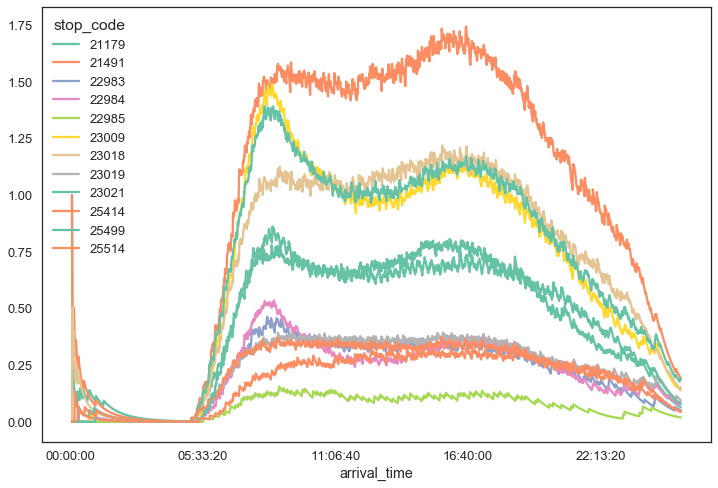

In [12]:
allenby_north = ['21179', '25414', '22983', '22984', '21491', '22985', '23021', '25514', '23018', '23009', '23019', '25499']
dfa = df[df.stop_code.isin(allenby_north)]
dfa['departure_time'] = pd.Timestamp(year=2019, month=3, day=14) + dfa.departure_time
dfa.groupby('stop_code').resample('1T', on='arrival_time').size().unstack(level=0).resample('1T').sum().fillna(0).ewm(60).mean().plot(figsize=(12,8))

In [13]:
#df['arrival_time'] = pd.Timestamp(year=2019, month=3, day=14) + df.arrival_time

cnt = df.groupby(['stop_code', pd.Grouper(freq='1T', key='arrival_time')]).size()

In [14]:
cong_stops = cnt.unstack(level=0).resample('1T').sum().ewm(60).mean().quantile(.95, axis=0).sort_values(ascending=False)

In [15]:
feed.stops.groupby('stop_code').stop_id.nunique().sort_values(ascending=False)

stop_code
13907    23
21256    22
4170     20
33512    16
20001    14
30136    14
43009    13
50093    12
55637    12
47962    11
31100    11
57001    11
11001    10
34924     8
33077     8
19988     8
42658     8
42659     8
31654     8
51437     8
28624     8
41533     7
22955     6
10030     6
10466     6
28625     6
53408     5
58002     5
10313     5
55579     5
         ..
50645     1
50646     1
50647     1
50620     1
5062      1
50619     1
50604     1
50595     1
50596     1
50597     1
50598     1
50599     1
506       1
5060      1
50600     1
50601     1
50602     1
50605     1
50618     1
50606     1
50607     1
50608     1
5061      1
50610     1
50611     1
50612     1
50615     1
50616     1
50617     1
1         1
Name: stop_id, Length: 27375, dtype: int64

In [16]:
pd.concat([cong_stops, feed.stops.drop_duplicates(subset='stop_code').set_index('stop_code').stop_name, feed.stops.groupby('stop_code').stop_id.nunique()], axis=1).sort_values(0.95, ascending=False).head(20)

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0.95,stop_name,stop_id
21472,3.060249,קניון עזריאלי/דרך בגין,1
21675,2.859015,גשר קלקא/דרך בגין,1
21221,2.410337,גשר קלקא/דרך בגין,1
25071,2.246669,סמינר הקיבוצים/דרך נמיר,1
21188,2.111086,דרך נמיר/יהודה המכבי,1
23014,2.061492,קניון עזריאלי/דרך בגין,1
28627,2.050277,ת. מרכזית ת''א ק. 6/הורדה,1
5059,1.932330,ירמיהו/אלקנה,1
4014,1.863494,ירמיהו/מנחת יצחק,1
28665,1.806691,הבורסה/דרך ז'בוטינסקי,1


In [17]:
pd.concat([cong_stops, feed.stops.drop_duplicates(subset='stop_code').set_index('stop_code').stop_name, feed.stops.groupby('stop_code').stop_id.nunique()], axis=1).sort_values(0.95, ascending=False).head(20).index

C:\Users\dbare\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Index(['21472', '21675', '21221', '25071', '21188', '23014', '28627', '5059',
       '4014', '28665', '5058', '26956', '32269', '34063', '5200', '43008',
       '21109', '4013', '21415', '21491'],
      dtype='object')

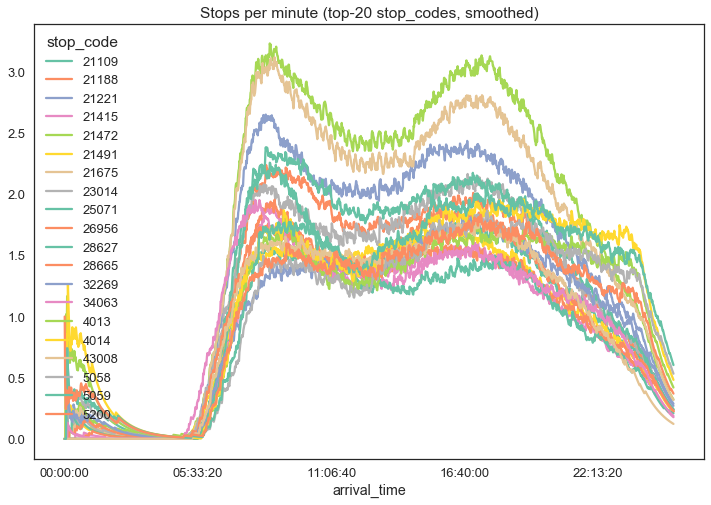

In [18]:
top_cong_sc = ['21472', '21675', '21221', '25071', '21188', '23014', '28627', '5059',
       '4014', '28665', '5058', '26956', '32269', '34063', '5200', '43008',
       '21109', '4013', '21415', '21491']
dft = df[df.stop_code.isin(top_cong_sc)]
dft.groupby('stop_code').resample('1T', on='arrival_time').size().unstack(level=0).resample('1T').sum().fillna(0).ewm(60).mean().plot(figsize=(12,8), title="Stops per minute (top-20 stop_codes, smoothed)")

In [19]:
dfa.groupby(['stop_code', 'stop_name']).size().sort_values().reset_index().stop_name.tolist()

['אלנבי/מונטיפיורי',
 "אלנבי/מזא''ה",
 'אלנבי/שדרות רוטשילד',
 'אלנבי/אחד העם',
 'אלנבי/לילינבלום',
 'אלנבי/ביאליק',
 'אלנבי/יונה הנביא',
 'אלנבי/יהודה הלוי',
 'שוק הכרמל/אלנבי',
 'אלנבי/בלפור',
 "אלנבי/מזא''ה",
 'בית הכנסת הגדול/אלנבי']

In [20]:
dfa.head()

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,route_id,direction_id,route_short_name,route_long_name,agency_id,agency_name,zone_name
5757,10489962_130319,2019-03-15 00:29:30,1 days 00:29:30,13292,29,אלנבי/שדרות רוטשילד,32.062794,34.773273,22983,11205,0,222,מבוא רעות/שד. האורנים-מודיעין מכבים רעות<->מסו...,18,קווים,גוש דן
5758,10489962_130319,2019-03-15 00:30:29,1 days 00:30:29,13115,30,בית הכנסת הגדול/אלנבי,32.064694,34.772553,21491,11205,0,222,מבוא רעות/שד. האורנים-מודיעין מכבים רעות<->מסו...,18,קווים,גוש דן
5759,10489962_130319,2019-03-15 00:31:04,1 days 00:31:04,13326,31,אלנבי/מזא''ה,32.066605,34.771697,23021,11205,0,222,מבוא רעות/שד. האורנים-מודיעין מכבים רעות<->מסו...,18,קווים,גוש דן
5760,10489962_130319,2019-03-15 00:32:18,1 days 00:32:18,13315,32,שוק הכרמל/אלנבי,32.068872,34.770828,23009,11205,0,222,מבוא רעות/שד. האורנים-מודיעין מכבים רעות<->מסו...,18,קווים,גוש דן
5761,10489962_130319,2019-03-15 00:33:06,1 days 00:33:06,13324,33,אלנבי/ביאליק,32.070517,34.770191,23019,11205,0,222,מבוא רעות/שד. האורנים-מודיעין מכבים רעות<->מסו...,18,קווים,גוש דן


In [21]:
dfa = dfa.merge(feed.routes[['route_id', 'route_desc']], on='route_id', how='left')

In [22]:
dfa['route_mkt'] = dfa.route_desc.str.split('-', expand=True).loc[:, 0]

In [23]:
dfa.route_mkt.nunique()

54

In [24]:
pd.qcut(dfa.assign(route_id = dfa.route_id.astype(int)).groupby('route_mkt').trip_id.nunique(), 10).value_counts(sort=False)

(0.999, 2.0]      7
(2.0, 3.6]        4
(3.6, 14.8]       5
(14.8, 35.2]      6
(35.2, 52.0]      5
(52.0, 65.0]      6
(65.0, 74.0]      6
(74.0, 86.0]      4
(86.0, 114.7]     5
(114.7, 159.0]    6
Name: trip_id, dtype: int64

In [25]:
se = (dfa.groupby(['trip_id'])
     .departure_time.agg(['min', 'max']).rename(columns={'min': 'departure_time', 'max': 'arrival_time'})
     .sort_values(['arrival_time', 'departure_time']))
se.head()

,departure_time,arrival_time
trip_id,,
33629226_130319,2019-03-14 00:04:04,2019-03-14 00:04:04
29300251_130319,2019-03-14 00:04:01,2019-03-14 00:05:30
35896258_130319,2019-03-14 00:07:34,2019-03-14 00:09:03
36914007_130319,2019-03-14 00:09:56,2019-03-14 00:11:10
29301181_130319,2019-03-14 00:14:21,2019-03-14 00:15:51


In [26]:
se['arrival_time'] = se.arrival_time + pd.Timedelta(2, unit='m')
se['departure_time'] = se.departure_time - pd.Timedelta(2, unit='m')

In [27]:
se.head()

,departure_time,arrival_time
trip_id,,
33629226_130319,2019-03-14 00:02:04,2019-03-14 00:06:04
29300251_130319,2019-03-14 00:02:01,2019-03-14 00:07:30
35896258_130319,2019-03-14 00:05:34,2019-03-14 00:11:03
36914007_130319,2019-03-14 00:07:56,2019-03-14 00:13:10
29301181_130319,2019-03-14 00:12:21,2019-03-14 00:17:51


In [28]:
departures = pd.Series(1, se.departure_time).resample('1T').sum().asfreq('1Min')

departures.head()

departure_time
2019-03-14 00:02:00    2
2019-03-14 00:03:00    0
2019-03-14 00:04:00    0
2019-03-14 00:05:00    1
2019-03-14 00:06:00    0
Freq: T, dtype: int64

In [29]:
arrivals =  pd.Series(1, se.arrival_time).resample('1T').sum().asfreq('1Min')
arrivals.head()

arrival_time
2019-03-14 00:06:00    1
2019-03-14 00:07:00    1
2019-03-14 00:08:00    0
2019-03-14 00:09:00    0
2019-03-14 00:10:00    0
Freq: T, dtype: int64

In [30]:
onroad = pd.concat([pd.Series(1, se.departure_time),  # departed add 1
                           pd.Series(-1, se.arrival_time)  # arrived substract 1
                           ]).resample('1Min').sum().cumsum().ffill()
da = (pd.concat([departures, arrivals, onroad], axis=1).reset_index()
        .rename(columns={'index': 'time', 0:'departures', 1:'arrivals', 2:'onroad'}))
da.head()

,departure_time,departures,arrivals,onroad
0,2019-03-14 00:02:00,2.0,NaN,2
1,2019-03-14 00:03:00,0.0,NaN,2
2,2019-03-14 00:04:00,0.0,NaN,2
3,2019-03-14 00:05:00,1.0,NaN,3
4,2019-03-14 00:06:00,0.0,1.0,2


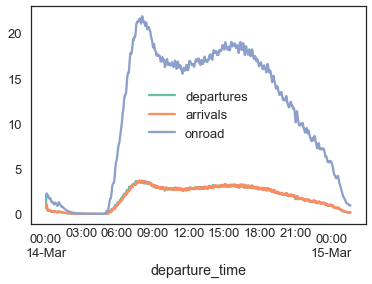

In [31]:
(da.set_index('departure_time')
 .ewm(span=60)
 .mean()
 .plot())

## shapes

In [14]:
feed.shapes.shape

(5654870, 4)

In [15]:
feed.shapes.shape_id.nunique()

6550

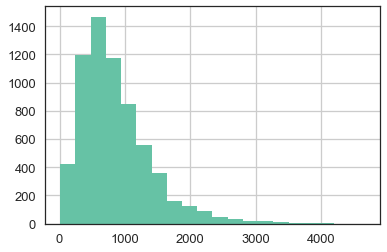

In [16]:
feed.shapes.groupby('shape_id').shape_pt_sequence.nunique().hist(bins=20)

In [30]:
feed.trips[feed.trips.route_id=='14205'].shape_id.value_counts()

87951    31
Name: shape_id, dtype: int64

In [31]:
feed.shapes[feed.shapes.shape_id=='87951'].to_csv('data/route_id_14205_shape_id_87951.csv.gz', compression='gzip', index=False)

In [3]:
from glob import glob
import datetime

In [4]:
def get_closest_path(date, path_to_format):
    for i in range(100):
        date_str = datetime.datetime.strftime(date - datetime.timedelta(i), '%Y-%m-%d')
        path_to_try = path_to_format.format(date_str)
        if os.path.exists(path_to_try):
            return path_to_try
    return None

In [5]:
import os
out_dir = 'data\\shapes'
#os.mkdir(out_dir)

In [6]:
#pat = 'data\\gtfs_feeds\\2019-0[2-3]*'
#pat = 'data\\gtfs_feeds\\2019-03-20*'
gtfs_dir = 'data\\gtfs_feeds'
file_pat = '{}.zip'
start_date = datetime.datetime.strptime('2018-10-01', '%Y-%m-%d').date()
end_date = datetime.date.today()

delta = end_date - start_date 

for i in range(delta.days + 1):
    date = start_date + datetime.timedelta(i)
    date_str = datetime.datetime.strftime(date, '%Y-%m-%d')
    out_path = os.path.join(out_dir, date_str+'_shapes.csv.gz')
    if not os.path.exists(out_path):
        path_to_format = os.path.join(gtfs_dir, file_pat)
        f = get_closest_path(date, path_to_format)
        print(date, f)
        feed = get_partridge_feed_by_date(f, date)
        t = feed.trips
        s = feed.shapes
        print(s.shape)
        s = s.merge(t[['route_id', 'shape_id']].drop_duplicates(), how='left')
        #s['shape_id'] = s.shape_id.astype(int)
        #s['route_id'] = s.route_id.astype(int)
        #s.to_hdf(os.path.join(out_dir,'shape_store.h5'), date_str, append=True)
        s.to_csv(out_path, index=False, compression='gzip')


2018-12-05 data\gtfs_feeds\2018-12-05.zip
(5552658, 4)
2018-12-06 data\gtfs_feeds\2018-12-06.zip
(5636979, 4)
2018-12-07 data\gtfs_feeds\2018-12-07.zip
(4450366, 4)
2018-12-08 data\gtfs_feeds\2018-12-08.zip
(2899755, 4)
2018-12-09 data\gtfs_feeds\2018-12-09.zip
(5659909, 4)
2018-12-10 data\gtfs_feeds\2018-12-10.zip
(5417510, 4)
2018-12-11 data\gtfs_feeds\2018-12-11.zip
(5690228, 4)
2018-12-12 data\gtfs_feeds\2018-12-12.zip
(5699901, 4)
2018-12-13 data\gtfs_feeds\2018-12-13.zip
(5836108, 4)
2018-12-14 data\gtfs_feeds\2018-12-14.zip
(4855459, 4)
2018-12-15 data\gtfs_feeds\2018-12-15.zip
(2896985, 4)
2018-12-16 data\gtfs_feeds\2018-12-16.zip
(5904389, 4)
2018-12-17 data\gtfs_feeds\2018-12-17.zip
(5685134, 4)
2018-12-18 data\gtfs_feeds\2018-12-18.zip
(5647214, 4)
2018-12-19 data\gtfs_feeds\2018-12-19.zip
(5702777, 4)
2018-12-20 data\gtfs_feeds\2018-12-20.zip
(5840323, 4)
2018-12-21 data\gtfs_feeds\2018-12-21.zip
(4857389, 4)
2018-12-22 data\gtfs_feeds\2018-12-22.zip
(2915664, 4)
2018-12-23

### only diffs
1. output only changed route_ids shapes
1. create one table with added columns start_date, end_date

In [14]:
state = {}

def check_rs(g):
    rid = g.route_id.iat[0]
    g = g.sort_values(['shape_id', 'shape_pt_sequence']).reset_index().drop('index', axis=1)
    if rid in state:
        if g.equals(state[rid]):
            return False
    state[rid] = g
    return True

sc_out = os.path.join(out_dir, 'dif')
#os.mkdir(sc_out)

for f in glob(out_dir+'\\*'):
    date_str = os.path.basename(f).split('_')[0]
    print(date_str)
    s = pd.read_csv(f, compression='gzip')
    print(s.shape)
    grouped = s.groupby('route_id')
    filt = grouped.filter(check_rs).sort_values(['route_id', 'shape_id', 'shape_pt_sequence'])
    filt
    print(filt.shape)
    filt.to_csv(os.path.join(sc_out, date_str+'_shapes_dif.csv.gz'), compression='gzip', index=False)

2018-10-01
(2891684, 5)
(2891684, 5)
2018-10-02
(5347256, 5)
(3212773, 5)
2018-10-03
(5726605, 5)
(602379, 5)
2018-10-04
(5853757, 5)
(47891, 5)
2018-10-05
(4873640, 5)
(406933, 5)
2018-10-06
(2885991, 5)
(45859, 5)
2018-10-07
(5963393, 5)
(50269, 5)
2018-10-08
(5711218, 5)
(960, 5)
2018-10-09
(5698782, 5)
(4406, 5)
2018-10-10
(5716938, 5)
(9212, 5)
2018-10-11
(5873189, 5)
(25468, 5)
2018-10-12
(4867002, 5)
(20110, 5)
2018-10-13
(2885399, 5)
(1306, 5)
2018-10-14
(5992560, 5)
(246939, 5)
2018-10-15
(5728706, 5)
(123680, 5)
2018-10-16
(5729976, 5)
(4525, 5)
2018-10-17
(5747861, 5)
(26275, 5)
2018-10-18
(5889009, 5)
(35936, 5)
2018-10-19
(4840502, 5)
(67137, 5)
2018-10-20
(2897918, 5)
(46309, 5)
2018-10-21
(5995135, 5)
(45180, 5)
2018-10-22
(5736628, 5)
(1340, 5)
2018-10-23
(5736945, 5)
(10057, 5)
2018-10-24
(5760006, 5)
(7173, 5)
2018-10-25
(5905931, 5)
(7549, 5)
2018-10-26
(4860381, 5)
(27212, 5)
2018-10-27
(2901750, 5)
(4399, 5)
2018-10-28
(6000238, 5)
(51195, 5)
2018-10-29
(5739220, 5

PermissionError: [Errno 13] Permission denied: 'data\\shapes\\dif'

In [15]:
alls = []
for f in glob(sc_out+'\\*'):
    date_str = os.path.basename(f).split('_')[0]
    s = pd.read_csv(f, compression='gzip')
    s['date'] = date_str
    alls.append(s)
    
ss = pd.concat(alls)


In [16]:
ss.shape

(12879703, 6)

In [17]:
ss.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,route_id,date
0,97105,31.890894,34.731634,1,1,2018-10-01
1,97105,31.890812,34.731346,2,1,2018-10-01
2,97105,31.890764,34.731283,3,1,2018-10-01
3,97105,31.890435,34.731110,4,1,2018-10-01
4,97105,31.890394,34.731117,5,1,2018-10-01


In [19]:
ss.to_csv(os.path.join(sc_out, 'shapes_dif_20181001-20190320.csv.gz'), index=False, compression='gzip')

In [21]:
ss.dtypes

shape_id              object
shape_pt_lat         float64
shape_pt_lon         float64
shape_pt_sequence     object
route_id              object
date                  object
dtype: object

In [26]:
ss[ss.route_id.isin([20912, 20916, 20917, 20920, 5214, 5189])].to_csv(os.path.join(sc_out, 'hackathon_shapes_dif_1.csv.gz'), index=False, compression='gzip')

In [28]:
ss[ss.route_id.isin([20912, 20916, 20917, 20920, 5214, 5189])].groupby('route_id').shape_id.nunique()

route_id
5189     3
5214     1
20912    2
20916    3
20917    3
20920    2
Name: shape_id, dtype: int64

## stop_desc

In [8]:
feed.stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id
0,1,38831,בי''ס בר לב/בן יהודה,רחוב:בן יהודה 76 עיר: כפר סבא רציף: קומה:,32.183939,34.917812,0,NaN,6900
1,2,38832,הרצל/צומת בילו,רחוב:הרצל עיר: קרית עקרון רציף: קומה:,31.870034,34.819541,0,NaN,469
2,3,38833,הנחשול/הדייגים,רחוב:הנחשול 30 עיר: ראשון לציון רציף: קומה:,31.984553,34.782828,0,NaN,8300
3,4,38834,פריד/ששת הימים,רחוב:משה פריד 9 עיר: רחובות רציף: קומה:,31.888550,34.790904,0,NaN,8400
4,6,38836,ת. מרכזית לוד/הורדה,רחוב: עיר: לוד רציף: קומה:,31.956576,34.898125,0,NaN,7000


In [9]:
fields = { 'street': 'רחוב', 
           'city': 'עיר', 
           'platform': 'רציף', 
           'floor': 'קומה' }

prefix='stop_desc_'

STOP_DESC_RE = ''
for n, fld in fields.items():
    STOP_DESC_RE += fld+f':(?P<{prefix+n}>.*)'
    
STOP_DESC_RE

'רחוב:(?P<stop_desc_street>.*)עיר:(?P<stop_desc_city>.*)רציף:(?P<stop_desc_platform>.*)קומה:(?P<stop_desc_floor>.*)'

In [10]:
#STOP_DESC_RE = 'רחוב:(.*)עיר:(.*)רציף:(.*)קומה:(.*)'

In [11]:
feed.stops.stop_desc.iat[0]

'רחוב:בן יהודה 76 עיר: כפר סבא רציף:   קומה:'

In [12]:
sd = feed.stops.stop_desc.str.extract(STOP_DESC_RE).apply(lambda x: x.str.strip())

sd.head()

,stop_desc_street,stop_desc_city,stop_desc_platform,stop_desc_floor
0,בן יהודה 76,כפר סבא,,
1,הרצל,קרית עקרון,,
2,הנחשול 30,ראשון לציון,,
3,משה פריד 9,רחובות,,
4,,לוד,,


In [13]:
s = pd.concat([feed.stops, sd], axis=1)

In [15]:
s[(s.stop_desc_city=='ערד')]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id,stop_desc_street,stop_desc_city,stop_desc_platform,stop_desc_floor
9263,12100,10204,צומת ערד,רחוב:31 עיר: ערד רציף: קומה:,31.254819,35.210922,0,NaN,13493,31,ערד,,
9340,12210,10314,מבצע לוט/סיירים,רחוב:מבצע לוט 6 עיר: ערד רציף: קומה:,31.258487,35.219357,0,NaN,2560,מבצע לוט 6,ערד,,
9360,12247,10351,ת. מרכזית ערד,רחוב:יהודה 49 עיר: ערד רציף: קומה:,31.256155,35.211140,0,NaN,2560,יהודה 49,ערד,,
9411,12346,10450,יהודה/חן,רחוב:יהודה עיר: ערד רציף: קומה:,31.260446,35.215994,0,NaN,2560,יהודה,ערד,,
9433,12386,10490,מואב/נוף,רחוב:מואב 52 עיר: ערד רציף: קומה:,31.261357,35.223118,0,NaN,2560,מואב 52,ערד,,
9553,12647,10752,אשד/יובל,רחוב:אשד 33 עיר: ערד רציף: קומה:,31.252282,35.199914,0,NaN,2560,אשד 33,ערד,,
9586,12736,10842,קנאים-בי''ס טללים,רחוב:הקנאים 45 עיר: ערד רציף: קומה:,31.258599,35.205482,0,NaN,2560,הקנאים 45,ערד,,
9587,12737,10843,עוזיהו-תלמוד תורה,רחוב:עוזיהו עיר: ערד רציף: קומה:,31.256539,35.202587,0,NaN,2560,עוזיהו,ערד,,
9602,12771,10877,מעון/תפוח,רחוב:מעון עיר: ערד רציף: קומה:,31.261837,35.202178,0,NaN,2560,מעון,ערד,,
18905,25817,11281,משמר/שוהם,רחוב:משמר 6 עיר: ערד רציף: קומה:,31.268117,35.225551,0,NaN,2560,משמר 6,ערד,,


In [26]:
arad_stops = s[(s.stop_desc_city=='ערד')].stop_code
arad_routes = df[df.stop_code.isin(arad_stops)].route_id.unique()
df[df.route_id.isin(arad_routes)]

,trip_id,departure_time,arrival_time,stop_id,stop_sequence,stop_name,stop_lat,stop_lon,stop_code,route_id,direction_id,route_short_name,route_long_name,agency_id,agency_name,zone_name
11069,11428565_270319,10:25:00,10:25:00,37122,1,ת. מרכזית ב''ש/רציפים,31.243017,34.796743,13907,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11070,11428565_270319,10:28:30,10:28:30,26122,2,בית רסקו/יצחק רגר,31.247534,34.797807,13107,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11071,11428565_270319,10:33:00,10:33:00,26665,3,מרכז רפואי סורוקה/שדרות בן גוריון,31.260919,34.799354,13943,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11072,11428565_270319,10:35:03,10:35:03,26689,4,מעונות הסטודנטים/שדרות בן גוריון,31.260746,34.806383,13992,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11073,11428565_270319,10:35:38,10:35:38,40150,5,תחנת רכבת/שדרות דוד בן גוריון,31.260328,34.809044,11602,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11074,11428565_270319,10:36:21,10:36:21,26873,6,שדרות דוד בן גוריון/דרך השלום,31.258157,34.811462,14381,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11075,11428565_270319,10:38:44,10:38:44,26848,7,שדרות דוד בן גוריון/יעקב גרשפלד,31.252951,34.814632,14336,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11076,11428565_270319,10:40:26,10:40:26,26700,8,דרך אליהו נאוי/שדרות דוד בן גוריון,31.250160,34.819163,14015,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,באר שבע
11077,11428565_270319,10:44:09,10:44:09,26715,9,צומת עומר מערב,31.269960,34.842773,14047,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,עומר חורה
11078,11428565_270319,10:49:11,10:49:11,26906,10,צומת שוקת,31.306148,34.900711,14429,8179,0,386,ת. מרכזית ב''ש/רציפים-באר שבע<->ת. מרכזית ערד-...,15,מטרופולין,עומר חורה


In [29]:
df[df.route_id.isin(arad_routes)].to_csv('data/arad_stop_times.csv.gz', compression='gzip', index=False)

In [116]:
s[(s.stop_desc_city=='תל אביב יפו') & (s.stop_desc_street.str.contains('אבן גבירול')) ]

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,location_type,parent_station,zone_id,stop_desc_street,stop_desc_city,stop_desc_platform,stop_desc_floor
9692,12878,21123,עיריית ת''א/אבן גבירול,רחוב:אבן גבירול 88 עיר: תל אביב יפו רציף: קומה:,32.082493,34.781427,0,NaN,5000,אבן גבירול 88,תל אביב יפו,,
9695,12881,21127,אבן גבירול/פנקס,רחוב:אבן גבירול 154 עיר: תל אביב יפו רציף: ק...,32.089768,34.782736,0,NaN,5000,אבן גבירול 154,תל אביב יפו,,
9696,12882,21128,אבן גבירול/שד' נורדאו,רחוב:אבן גבירול 155 עיר: תל אביב יפו רציף: ק...,32.091212,34.782786,0,NaN,5000,אבן גבירול 155,תל אביב יפו,,
9708,12896,21157,אבן גבירול/ארלוזרוב,רחוב:אבן גבירול 103 עיר: תל אביב יפו רציף: ק...,32.086336,34.781859,0,NaN,5000,אבן גבירול 103,תל אביב יפו,,
9709,12897,21158,אבן גבירול/ארלוזרוב,רחוב:אבן גבירול 120 עיר: תל אביב יפו רציף: ק...,32.086059,34.782024,0,NaN,5000,אבן גבירול 120,תל אביב יפו,,
9876,13127,21516,כיכר רבין/אבן גבירול,רחוב:אבן גבירול 63 עיר: תל אביב יפו רציף: קומה:,32.078796,34.781162,0,NaN,5000,אבן גבירול 63,תל אביב יפו,,
10045,13318,23012,כיכר מילאנו/אבן גבירול,רחוב:אבן גבירול 186 עיר: תל אביב יפו רציף: ק...,32.094344,34.783628,0,NaN,5000,אבן גבירול 186,תל אביב יפו,,
10276,13593,25623,אבן גבירול/קרליבך,רחוב:אבן גבירול 6 עיר: תל אביב יפו רציף: קומה:,32.071922,34.781961,0,NaN,5000,אבן גבירול 6,תל אביב יפו,,
10277,13594,25624,אבן גבירול/דיזנגוף,רחוב:אבן גבירול 15 עיר: תל אביב יפו רציף: קומה:,32.072576,34.781706,0,NaN,5000,אבן גבירול 15,תל אביב יפו,,
10278,13595,25625,אבן גבירול/שד' שאול המלך,רחוב:אבן גבירול 26 עיר: תל אביב יפו רציף: קומה:,32.074469,34.781836,0,NaN,5000,אבן גבירול 26,תל אביב יפו,,


In [111]:
stop_codes = {  'allenby_stops_codes': s[(s.stop_desc_city=='תל אביב יפו') & (s.stop_desc_street.str.contains('אלנבי')) ].stop_code.tolist(),
                'shaul_hamelech_stop_codes': s[(s.stop_desc_city=='תל אביב יפו') & (s.stop_desc_street.str.contains('שאול המלך')) ].stop_code.tolist(),
                'hamasger': s[(s.stop_desc_city=='תל אביב יפו') & (s.stop_desc_street.str.contains('המסגר')) ].stop_code.tolist(),
                'namir': s[(s.stop_desc_city=='תל אביב יפו') & (s.stop_desc_street.str.contains('דרך נמיר')) ].stop_code.tolist(),
                'zabotinsky': s[((s.stop_desc_city=='תל אביב יפו') | (s.stop_desc_city=='פתח תקווה') | (s.stop_desc_city=='בני ברק') | (s.stop_desc_city=='רמת גן')) & (s.stop_desc_street.str.contains('ז\'בוטינסקי')) ].stop_code.tolist(),
                'hebron': s[(s.stop_desc_city=='ירושלים') & (s.stop_desc_street.str.contains('דרך חברון')) ].stop_code.tolist(),
                'yirmiyahu': s[(s.stop_desc_city=='ירושלים') & (s.stop_desc_street.str.contains('ירמיהו')) ].stop_code.tolist(),
                'balfour': s[(s.stop_desc_city=='בת ים') & (s.stop_desc_street.str.contains('בלפור')) ].stop_code.tolist(),
                'ibn_gabirol': s[(s.stop_desc_city=='תל אביב יפו') & (s.stop_desc_street.str.contains('אבן גבירול')) ].stop_code.tolist(),
             }

stop_codes

{'allenby_stops_codes': ['21179',
  '21445',
  '21490',
  '21491',
  '22983',
  '22984',
  '22985',
  '22988',
  '22989',
  '22990',
  '23009',
  '23018',
  '23019',
  '23020',
  '23021',
  '25368',
  '25369',
  '25409',
  '25414',
  '25420',
  '25499',
  '25508',
  '25512',
  '25514',
  '25531',
  '25532',
  '26983',
  '27228'],
 'balfour': ['36104',
  '36207',
  '36214',
  '36215',
  '36216',
  '36221',
  '36232',
  '36233',
  '37473'],
 'hamasger': ['22945',
  '22946',
  '22947',
  '23016',
  '23017',
  '25702',
  '20004',
  '20026',
  '20356',
  '28660',
  '20143'],
 'hebron': ['60413',
  '60414',
  '517',
  '518',
  '523',
  '680',
  '681',
  '3120',
  '3121',
  '3824',
  '5806',
  '6293'],
 'ibn_gabirol': ['21123',
  '21127',
  '21128',
  '21157',
  '21158',
  '21516',
  '23012',
  '25623',
  '25624',
  '25625',
  '25631',
  '25632',
  '25634',
  '25635',
  '25817',
  '25818',
  '25823',
  '25829',
  '25852',
  '25868',
  '25869',
  '25893',
  '28561',
  '28596',
  '28622',
  '20

In [112]:
for s, codes in stop_codes.items():
    print(f'\n***{s}***:\nall_stop_code="'+'" OR all_stop_code="'.join(codes)+'"')


***allenby_stops_codes***:
all_stop_code="21179" OR all_stop_code="21445" OR all_stop_code="21490" OR all_stop_code="21491" OR all_stop_code="22983" OR all_stop_code="22984" OR all_stop_code="22985" OR all_stop_code="22988" OR all_stop_code="22989" OR all_stop_code="22990" OR all_stop_code="23009" OR all_stop_code="23018" OR all_stop_code="23019" OR all_stop_code="23020" OR all_stop_code="23021" OR all_stop_code="25368" OR all_stop_code="25369" OR all_stop_code="25409" OR all_stop_code="25414" OR all_stop_code="25420" OR all_stop_code="25499" OR all_stop_code="25508" OR all_stop_code="25512" OR all_stop_code="25514" OR all_stop_code="25531" OR all_stop_code="25532" OR all_stop_code="26983" OR all_stop_code="27228"

***shaul_hamelech_stop_codes***:
all_stop_code="21100" OR all_stop_code="21150" OR all_stop_code="21303" OR all_stop_code="21544" OR all_stop_code="23025" OR all_stop_code="25722" OR all_stop_code="25732"

***hamasger***:
all_stop_code="22945" OR all_stop_code="22946" OR al

In [ ]:
rt_sc = df.groupby(['route_id', 'stop_code']).trip_id.nunique().reset_index()


In [89]:
route_ids = {}
for street, codes in stop_codes.items():
    route_ids[street] = list(rt_sc[rt_sc.stop_code.isin(codes)].route_id.unique())
route_ids

{'allenby_stops_codes': ['10119',
  '10120',
  '1027',
  '1028',
  '1034',
  '1035',
  '10373',
  '10497',
  '10933',
  '10934',
  '11089',
  '11205',
  '11818',
  '13760',
  '14025',
  '15106',
  '15107',
  '15116',
  '15117',
  '15747',
  '15748',
  '16130',
  '16131',
  '17054',
  '17055',
  '17195',
  '17196',
  '17826',
  '17827',
  '17906',
  '17911',
  '17912',
  '19353',
  '19354',
  '19600',
  '20407',
  '20813',
  '20849',
  '20850',
  '21697',
  '21698',
  '21999',
  '2243',
  '2244',
  '2255',
  '2256',
  '2259',
  '22825',
  '22826',
  '2296',
  '22987',
  '2314',
  '2319',
  '2320',
  '2323',
  '2324',
  '2326',
  '2327',
  '2328',
  '2332',
  '23378',
  '2340',
  '2342',
  '2343',
  '2358',
  '2359',
  '2367',
  '2369',
  '2373',
  '2376',
  '2377',
  '2379',
  '2381',
  '2382',
  '23920',
  '23921',
  '23923',
  '23991',
  '24038',
  '24039',
  '24040',
  '2415',
  '2416',
  '2419',
  '2420',
  '24224',
  '2439',
  '2441',
  '2510',
  '2511',
  '2512',
  '2517',
  '2519

In [90]:
{street: len(rids) for street, rids in route_ids.items()}

{'allenby_stops_codes': 147,
 'balfour': 38,
 'hamasger': 277,
 'hebron': 49,
 'namir': 190,
 'shaul_hamelech_stop_codes': 52,
 'yirmiyahu': 246,
 'zabotinsky': 355}

In [95]:
sum([num for s, num in {street: len(rids) for street, rids in route_ids.items()}.items()])

1354

In [92]:
all_rids = []
for s, rids in route_ids.items():
    all_rids.extend(rids)
    
all_rids = set(all_rids)
len(all_rids)

1028

In [96]:
df[df.route_id.isin(all_rids)].trip_id.nunique()

23115

## TripIdToDate

In [16]:
TITD_PATH = 'data/archive/2019-02-03/TripIdToDate.zip'

In [20]:
TITD_HEADER = ['LineDetailRecordId', 'OfficeLineId', 'Direction',
                'LineAlternative', 'FromDate', 'ToDate',
                'TripId', 'DayInWeek', 'DepartureTime', 'EXTRA']
titd = pd.read_csv(TITD_PATH, header=None, names=TITD_HEADER, skiprows=[0] ).drop('EXTRA', axis=1)
titd.head()

,LineDetailRecordId,OfficeLineId,Direction,LineAlternative,FromDate,ToDate,TripId,DayInWeek,DepartureTime
0,1,67001,1,#,02/11/2018 00:00:00,01/01/2200 00:00:00,30900053,1,05:10
1,1,67001,1,#,02/11/2018 00:00:00,01/01/2200 00:00:00,30900054,1,05:40
2,1,67001,1,#,02/11/2018 00:00:00,01/01/2200 00:00:00,30900055,1,06:00
3,1,67001,1,#,02/11/2018 00:00:00,01/01/2200 00:00:00,30900056,1,06:20
4,1,67001,1,#,02/11/2018 00:00:00,01/01/2200 00:00:00,30900057,1,08:45


## Use daily other files

## Check gtfs_stats output

In [117]:
rs_path = 'data/gtfs_stats_hack/2019-03-11_route_stats.pkl.gz'

rs = pd.read_pickle(rs_path)

rs.head().T

,0,1,2,3,4
route_id,1,10,10000,10001,10002
route_short_name,1,4,91,91,92
agency_id,25,25,14,14,14
agency_name,אפיקים,אפיקים,נתיב אקספרס,נתיב אקספרס,נתיב אקספרס
route_long_name,ת. רכבת יבנה מערב-יבנה<->ת. רכבת יבנה מזרח-יבנ...,ת. רכבת יבנה מזרח-יבנה<->ת. רכבת יבנה מערב-יבנ...,קופת חולים/הנשיא-צפת<->דרך חטיבת יפתח-צפת-11,האר''י/ישראל ב''ק-צפת<->שפרינצק/קרן היסוד-צפת-2#,געתון/מירון-כפר ורדים<->בית ספר כפר ורדים-כפר ...
route_type,3,3,3,3,3
route_mkt,67001,47004,27091,27091,25092
route_direction,1,2,1,2,1
route_alternative,#,#,1,#,#
num_trips,26,35,1,5,1


In [124]:
rs[(rs.route_short_name=='25') & (rs.agency_name=='דן')]

,route_id,route_short_name,agency_id,agency_name,route_long_name,route_type,route_mkt,route_direction,route_alternative,num_trips,...,end_zone,num_zones,num_zones_missing,all_stop_latlon,all_stop_code,all_stop_id,all_stop_desc_city,all_start_time,all_trip_id,date
4330,2369,25,5,דן,מסוף האוניברסיטה-תל אביב יפו<->מרינה-בת ים-10,3,15025,1,0,82,...,גוש דן,1,0,"32.117554,34.804116;32.117385999999996,34.8059...",21508;20482;21734;20137;25075;21227;21385;2146...,13124;29568;13229;29398;13359;12936;13049;1310...,תל אביב יפו;תל אביב יפו;תל אביב יפו;תל אביב יפ...,08:05:00;08:15:00;08:25:00;08:34:00;08:43:00;0...,36921116_100319;36921117_100319;36921118_10031...,2019-03-11
4337,2373,25,5,דן,מסוף האוניברסיטה-תל אביב יפו<->מרינה-בת ים-13,3,15025,1,3,8,...,גוש דן,1,0,"32.117554,34.804116;32.122078,34.798889;32.124...",21508;21234;26649;26688;26693;26689;21389;2138...,13124;12943;14113;14127;14131;14128;13052;1305...,תל אביב יפו;תל אביב יפו;תל אביב יפו;תל אביב יפ...,06:45:00;07:05:00;07:14:00;07:22:00;07:30:00;0...,36331418_100319;36331419_100319;36331420_10031...,2019-03-11
4344,2376,25,5,דן,מסוף האוניברסיטה-תל אביב יפו<->מרינה-בת ים-16,3,15025,1,6,12,...,גוש דן,1,0,"32.117554,34.804116;32.117385999999996,34.8059...",21508;20482;21734;20137;25075;21227;21385;2146...,13124;29568;13229;29398;13359;12936;13049;1310...,תל אביב יפו;תל אביב יפו;תל אביב יפו;תל אביב יפ...,06:56:00;08:59:00;10:03:00;11:05:00;11:54:00;1...,36331462_100319;36331463_100319;36331464_10031...,2019-03-11
4351,2377,25,5,דן,בית התפוצות/קלאוזנר-תל אביב יפו<->מרינה-בת ים-17,3,15025,1,7,5,...,גוש דן,1,0,"32.113359,34.80742;32.109701,34.80702;32.10670...",20137;25075;21227;21385;21469;26312;26635;2167...,29398;13359;12936;13049;13100;13947;14104;1320...,תל אביב יפו;תל אביב יפו;תל אביב יפו;תל אביב יפ...,05:30:00;05:55:00;06:15:00;06:30:00;23:50:00,36331525_100319;36331526_100319;36331527_10031...,2019-03-11
4360,2379,25,5,דן,מרינה-בת ים<->מסוף האוניברסיטה-תל אביב יפו-20,3,15025,2,0,89,...,גוש דן,1,0,"32.008577,34.737856;32.011267,34.740164;32.012...",36095;36101;36103;36130;33891;36206;36204;3621...,23907;23911;23913;23937;21940;23997;23995;2400...,בת ים;בת ים;בת ים;בת ים;בת ים;בת ים;בת ים;בת י...,05:43:00;05:57:00;06:08:00;06:16:00;06:24:00;0...,36921568_100319;36921569_100319;36921570_10031...,2019-03-11
4363,2381,25,5,דן,מרינה-בת ים<->מסוף האוניברסיטה-תל אביב יפו-26,3,15025,2,6,10,...,גוש דן,1,0,"32.008577,34.737856;32.011267,34.740164;32.012...",36095;36101;36103;36130;33891;36206;36204;3621...,23907;23911;23913;23937;21940;23997;23995;2400...,בת ים;בת ים;בת ים;בת ים;בת ים;בת ים;בת ים;בת י...,08:56:00;09:56:00;10:59:00;12:03:00;12:56:00;1...,36331554_100319;36331555_100319;36331556_10031...,2019-03-11
4371,2382,25,5,דן,מרינה-בת ים<->בית התפוצות/קלאוזנר-תל אביב יפו-27,3,15025,2,7,4,...,גוש דן,1,0,"32.008577,34.737856;32.011267,34.740164;32.012...",36095;36101;36103;36130;33891;36206;36204;3621...,23907;23911;23913;23937;21940;23997;23995;2400...,בת ים;בת ים;בת ים;בת ים;בת ים;בת ים;בת ים;בת י...,04:50:00;05:10:00;05:28:00;22:25:00,36331608_100319;36331609_100319;36331610_10031...,2019-03-11


In [123]:
rs[rs.route_mkt=='20054']

,route_id,route_short_name,agency_id,agency_name,route_long_name,route_type,route_mkt,route_direction,route_alternative,num_trips,...,end_zone,num_zones,num_zones_missing,all_stop_latlon,all_stop_code,all_stop_id,all_stop_desc_city,all_start_time,all_trip_id,date
743,11619,54,18,קווים,חפץ חיים/אבני נזר-מודיעין עילית<->משך חוכמה ז-...,3,20054,1,0,1,...,חבל מודיעין,1,0,"31.934339,35.046636;31.933888,35.0462099999999...",60254;65157;60382;60383;60261;60302;65156;6023...,7531;8488;7647;7648;7536;7570;8487;7516;7519;3...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,07:35:00,11798136_100319,2019-03-11
744,11620,54,18,קווים,משך חוכמה ב-מודיעין עילית<->שד. יחזקאל/רב ושמו...,3,20054,2,0,1,...,חבל מודיעין,1,0,"31.935171999999998,35.041803;31.934401,35.0405...",65161;60203;60202;65138;60299;60254;65157;6037...,8492;7495;7494;8470;7567;7531;8488;7636;7514;7...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,12:55:00,16846823_100319,2019-03-11
866,11823,54,18,קווים,חפץ חיים א-מודיעין עילית<->משך חכמה/השלה-מודיע...,3,20054,1,3,1,...,חבל מודיעין,1,0,"31.932683,35.045155;31.931609,35.044184;31.930...",60382;60383;60261;60237;60240;60239;60373;6037...,7647;7648;7536;7516;7519;7518;7639;7640;7523;3...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,08:10:00,12725300_100319,2019-03-11
1140,12302,54,18,קווים,השל''ה/מסילת ישרים-מודיעין עילית<->מכבי אש/שדר...,3,20054,2,4,1,...,חבל מודיעין,1,0,"31.932347999999998,35.038187;31.932201,35.0381...",63978;65383;63985;60225;60223;60355;60381;6021...,35050;36924;35057;7508;7506;7622;7646;7504;848...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,16:00:00,16846842_100319,2019-03-11
1141,12303,54,18,קווים,השל''ה/מסילת ישרים-מודיעין עילית<->חפץ חיים/נו...,3,20054,2,5,1,...,חבל מודיעין,1,0,"31.932201,35.038167;31.931371000000002,35.0387...",65383;63985;60388;60210;60212;60214;60216;6515...,36924;35057;7653;7499;7500;7502;7503;8488;7636...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,17:00:00,16846848_100319,2019-03-11
6180,8808,54,18,קווים,שד. יחזקאל/רב ושמואל-מודיעין עילית<->משך חכמה/...,3,20054,1,1,1,...,חבל מודיעין,1,0,"31.939021999999998,35.036677000000005;31.93752...",60287;60271;65155;60300;65156;60229;60386;6037...,7557;7546;8486;7568;8487;7512;7651;7636;7514;7...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,08:05:00,11176976_100319,2019-03-11
6181,8809,54,18,קווים,חפץ חיים/אבני נזר-מודיעין עילית<->משך חכמה/השל...,3,20054,1,2,1,...,חבל מודיעין,1,0,"31.934339,35.046636;31.933289000000002,35.0474...",60254;60252;60315;60248;65160;65159;65158;6038...,7531;7529;7583;7525;8491;8490;8489;7652;7621;7...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,08:05:00,10468297_100319,2019-03-11
6183,8811,54,18,קווים,השל''ה/מסילת ישרים-מודיעין עילית<->מכבי אש/שדר...,3,20054,2,1,1,...,חבל מודיעין,1,0,"31.932347999999998,35.038187;31.932201,35.0381...",63978;65383;65161;63985;60388;60210;60212;6021...,35050;36924;8492;35057;7653;7499;7500;7502;750...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,12:55:00,16846829_100319,2019-03-11
6184,8812,54,18,קווים,מסילת ישרים/מסוף-מודיעין עילית<->שערי תשובה/חז...,3,20054,2,2,1,...,חבל מודיעין,1,0,"31.935116999999998,35.03756;31.93627,35.039121...",65138;60299;60254;65157;60370;60233;60234;6037...,8470;7567;7531;8488;7636;7514;7515;7638;7569;7...,מודיעין עילית;מודיעין עילית;מודיעין עילית;מודי...,12:55:00,16846835_100319,2019-03-11


In [119]:
rs.groupby('route_mkt').route_id.nunique().sort_values(ascending=False)

route_mkt
11900    77
32020    15
24041    14
12174    13
33055    12
18058    12
10480    11
15019    11
15101    11
41081    11
15050    10
12185    10
27070    10
20054     9
10511     9
30072     9
13026     9
14102     8
13007     8
10274     8
70001     8
10110     8
19049     8
15013     8
22073     8
11500     8
21070     8
12350     8
39080     8
10561     8
         ..
20075     1
20074     1
34047     1
13218     1
20053     1
10950     1
34077     1
34081     1
34086     1
34087     1
34088     1
33094     1
33093     1
20087     1
33061     1
13147     1
11028     1
20099     1
33040     1
20098     1
20092     1
13167     1
33088     1
13168     1
33080     1
33083     1
33084     1
11002     1
20089     1
10003     1
Name: route_id, Length: 2769, dtype: int64

In [8]:
rs.start_stop_city.value_counts()

ירושלים                670
תל אביב יפו            388
חיפה                   334
באר שבע                210
נתניה                  178
פתח תקווה              153
בני ברק                130
אשדוד                  125
חדרה                   120
ראשון לציון            113
טבריה                  111
צפת                    106
אשקלון                 106
רמת גן                 100
רחובות                  98
כרמיאל                  96
מודיעין מכבים רעות      96
נצרת                    94
כפר סבא                 92
נצרת עילית              84
מודיעין עילית           82
נהריה                   77
רעננה                   72
עפולה                   70
בית שמש                 67
קרית שמונה              66
הרצליה                  61
אריאל                   60
רמלה                    57
קצרין                   55
                      ... 
עדי                      1
פרי גן                   1
רגבים                    1
קרית חינוך שדות נגב      1
גזר                      1
שפיר                     1
פ